Just a first draft, delete, modify as you want 

# Imports

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc

from helpers.readers import prepare_dataframes, read_dataframe_parquet

# Loading dataframes

In [18]:
movies = read_dataframe_parquet("merged/movies")
directors = read_dataframe_parquet("merged/directors")
awards = read_dataframe_parquet("merged/awards")

In [19]:
all_countries = movies["countries"]
split_countries = all_countries.str.split(',')
flat_list = [country.strip() for sublist in split_countries for country in sublist]
countries = sorted(set(flat_list))
print(f'We have movies from {len(countries)} countries in the world.')

We have movies from 143 countries in the world.


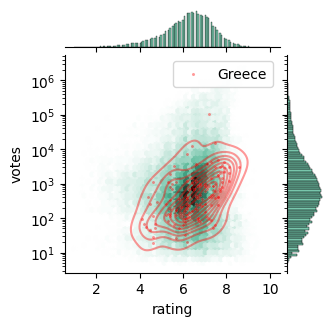

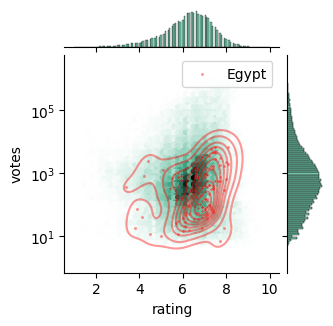

In [20]:
for country in ['Greece',"Egypt"]:#, 'Egypt', 'Argentina', 'Pakistan', 'Philippines']:
    g = sns.jointplot(x=movies.rating, y=movies.votes, kind='hex', color="#4CB391", joint_kws={'yscale': 'log'})
    g.fig.set_figwidth(3)  
    g.fig.set_figheight(3)  
    
    df = movies[movies.countries.str.contains(country) & ~movies.countries.str.contains(',')]
    sns.scatterplot(x=df.rating, y=df.votes, color='r', alpha=.4, s=5, ax=g.ax_joint, label=country)
    sns.kdeplot(x=df.rating, y=df.votes, color='r', alpha=.4, ax=g.ax_joint)
    g.ax_joint.legend()

### Movie score

In [21]:
%%time

def compute_score_vectorized(df):
    df['score'] = np.log10(df['votes']) * df['rating']
    return df

movies = compute_score_vectorized(movies)

CPU times: total: 0 ns
Wall time: 4.17 ms


In [22]:
def list_top_movies(country: str, top=5):
    cols = ['title', 'score', 'rating', 'votes', 'revenue', 'release', 'genres']
    display(movies[movies.countries.str.contains(country)].sort_values(by='score', ascending=False)[:top][cols])
    
list_top_movies('Iran')

,title,score,rating,votes,revenue,release,genres
tconst,,,,,,,
tt1832382,A Separation,44.848721,8.3,253198.0,NaN,2011,Drama
tt0118849,Children of Heaven,40.132846,8.2,78388.0,1628579.0,1997,"Family Film,Drama,Adventure,World cinema,Comedy"
tt1360860,About Elly,37.510196,7.9,55992.0,1350000.0,2009,"Mystery,Drama,World cinema"
tt0416960,Marmoulak,36.448384,8.4,21832.0,NaN,2004,Comedy
tt0100234,Close-up,35.589689,8.2,21888.0,NaN,1990,"Crime Fiction,Drama,World cinema,Documentary"


### Score for directors

In [23]:
len(movies[movies["directors"].str.contains(",", na=False)]) # some movies have multiple directors

6310

In [24]:
movies_exploded = movies.reset_index(drop=False).copy()

movies_exploded['directors'] = movies_exploded['directors'].str.split(',')
movies_exploded = movies_exploded.explode('directors')

len(movies_exploded[movies_exploded["directors"].str.contains(",", na=False)]) # after explode no more duplicates

0

```python
%%time
directors.reset_index(inplace=True)


def hits_metric(data, threshold):
    return data['score'].gt(threshold).sum()

def rate_metric(data, rate_threshold, vote_threshold):
    return data[(data['rating'] >= rate_threshold) & (data['votes'] >= vote_threshold)].shape[0]

def avg_top_n_scores(data, n):
    if len(data) >= n:
        return data.nlargest(n, 'score')['score'].mean()
    return pd.NA

grouped = movies_exploded.groupby('directors')
director_metrics = pd.DataFrame(index=grouped.groups.keys())

# Calculate each metric
director_metrics['hits-30'] = grouped.apply(hits_metric, threshold=30)
director_metrics['hits-40'] = grouped.apply(hits_metric, threshold=40)
director_metrics['hits-45'] = grouped.apply(hits_metric, threshold=45)
director_metrics['hits-50'] = grouped.apply(hits_metric, threshold=50)
director_metrics['rate-7.0'] = grouped.apply(rate_metric, rate_threshold=7.0, vote_threshold=1000)
director_metrics['rate-7.5'] = grouped.apply(rate_metric, rate_threshold=7.5, vote_threshold=1000)
director_metrics['rate-8.0'] = grouped.apply(rate_metric, rate_threshold=8.0, vote_threshold=1000)
director_metrics['rate-8.5'] = grouped.apply(rate_metric, rate_threshold=8.5, vote_threshold=1000)
for n in [3, 5, 10]:
    director_metrics[f'avg-{n}'] = grouped.apply(avg_top_n_scores, n=n)

director_metrics.reset_index(inplace=True)
director_metrics.rename(columns={'index': 'nconst'}, inplace=True)

# there is probably a way to optimize even further but for now 20mins => 3mins is sufficient, would probably involve 
# a smart grouping and mapping to avoid using apply()
```

In [25]:
# shortcut to not wait 2-3 mins (to remove for final run)
directors.reset_index(inplace=True)
director_metrics = read_dataframe_parquet("directors/metrics")

In [26]:
directors_with_country = pd.merge(
    director_metrics,
    movies_exploded[['directors', 'countries']],
    left_on='nconst',
    right_on='directors',
    how='left'
)

In [27]:
# minimal version
def list_top_directors(country: str, top=5, score='avg-3'):

    directors_in_country = directors_with_country[directors_with_country['countries'].str.contains(country, na=False)]

    grouped_directors = directors_in_country.groupby('nconst').agg({score: 'mean'})

    top_directors = grouped_directors.sort_values(by=score, ascending=False).head(top)

    return top_directors#.index.tolist()

list_top_directors('Iran', top=5)

,avg-3
nconst,
nm0327944,41.949604
nm0000080,40.353561
nm1410815,37.885910
nm0000576,35.739974
nm0006498,35.496518


In [28]:
# as in scores-sepehr
def list_top_directors(country: str, top=5, score='avg-3'):
    directors_in_country = directors_with_country[directors_with_country['countries'].str.contains(country, na=False)]
    grouped_directors = directors_in_country.groupby('nconst').agg({
        'hits-30': 'mean', 
        'hits-40': 'mean', 
        'hits-45': 'mean', 
        'hits-50': 'mean', 
        'rate-7.0': 'mean', 
        'rate-7.5': 'mean', 
        'rate-8.0': 'mean', 
        'rate-8.5': 'mean', 
        'avg-3': 'mean', 
        'avg-5': 'mean', 
        'avg-10': 'mean'
    })
    top_directors = grouped_directors.sort_values(by=score, ascending=False).head(top)
    
    top_directors_detailed = pd.merge(
        top_directors,
        directors[['nconst', 'primaryName', 'birthYear', 'deathYear', 'awardsNominated', 'awardsWon']],
        on='nconst',
        how='left'
    )
    columns_order = [
        'nconst', 'primaryName', 'birthYear', 'deathYear', 'awardsNominated', 'awardsWon',
        'hits-30', 'hits-40', 'hits-45', 'hits-50', 
        'rate-7.0', 'rate-7.5', 'rate-8.0', 'rate-8.5', 
        'avg-3', 'avg-5', 'avg-10'
    ]
    top_directors_detailed = top_directors_detailed[columns_order]
    
    return top_directors_detailed

list_top_directors('Iran', top=5)

,nconst,primaryName,birthYear,deathYear,awardsNominated,awardsWon,hits-30,hits-40,hits-45,hits-50,rate-7.0,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,avg-10
0,nm0327944,Alejandro G. Iñárritu,1963,<NA>,279,122,4.0,3.0,0.0,0.0,4.0,3.0,1.0,0.0,41.949604,37.726471,NaN
1,nm0000080,Orson Welles,1915,1985,57,33,8.0,2.0,1.0,0.0,12.0,8.0,2.0,0.0,40.353561,37.559267,34.21558
2,nm1410815,Asghar Farhadi,1972,<NA>,165,86,3.0,1.0,0.0,0.0,4.0,4.0,1.0,0.0,37.885910,NaN,NaN
3,nm0000576,Sean Penn,1960,<NA>,175,73,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,35.739974,31.874882,NaN
4,nm0006498,Majid Majidi,1959,<NA>,57,39,4.0,1.0,0.0,0.0,6.0,4.0,2.0,0.0,35.496518,32.781849,NaN


In [29]:
directors.set_index('nconst', inplace=True) # needed nconst as column for top_directors_detailed merge of list_top_directors

# Q1:  How impactful is the team surrounding the director on the success of a movie?


To answer to this question, we need additional information than what we already have in the `movies` & `directors` dataframe. Namely, the `imdb_people` and `imdb_principals` dataframe are of interest here.

- `imdb_people` contains birth/death years, primary professions and famous titles for ~12M people in the IMDb database

- `imdb_principals` contains the principal (max 10 per movie) people that have played in movies in the IMDb database (roughs out to ~58M rows)


They will thus be used to extract information about people that worked on the movies we selected. Their primary professions, the number of movies they played in, the potential nature of the roles they played in each movie (once actor, once writer, etc.)

We first retrieve 'reduce' these two dataframes to only contain information about the movies we decided to keep:

In [14]:
nmconsts = []
for item in movies.dropna(subset='directors').directors.str.split(','):
    nmconsts.extend(item)
nmconsts = set(nmconsts)

print(f'We have {len(nmconsts)} directors.')

We have 28478 directors.


In [30]:
%%time
imdb_info = read_dataframe_parquet(name='imdb/movies')
imdb_ratings = read_dataframe_parquet(name='imdb/ratings')
movieLens_movies = read_dataframe_parquet(name='movieLens/movies')
movieLens_ratings = read_dataframe_parquet('movieLens/ratings')

imdb_crew = read_dataframe_parquet(name='imdb/crew')
imdb_people = read_dataframe_parquet(name='imdb/names')
imdb_principals = read_dataframe_parquet(name='imdb/principals')

#directors = imdb_people[imdb_people.nconst.isin(nmconsts)].copy()
#directors = directors.set_index('nconst')

CPU times: total: 2min 6s
Wall time: 1min 37s


In [31]:
def matching_selected_people(imdb_people,imdb_principals,movies) : 

    """
    This function filters the IMDb dataframes for people that worked on the selected movies.

    Args :
        imdb_people : The IMDb 'basic' dataframe. Contains information about people, f.i the movies they are known most for.
        imdb_principals : The IMDb 'principals' dataframe. Contains information about the main cast of the IMDb movies, such as their name, job in the movie, role, etc.
        movies : The dataset of selected movies

    Returns :
        matched_imdb_people : The IMDb 'basic' dataframe matched for our selected movies
        jobs_principal_people : The IMDb 'principals' dataframe matched for our selected movies.
    """

    #Exploding the imdb people dataframe to have all films played by people in the dataframe
    imdb_people_exploded = imdb_people.copy()
    imdb_people_exploded['knownForTitles'] = imdb_people['knownForTitles'].str.split(',')
    imdb_people_exploded = imdb_people_exploded.explode(['knownForTitles'])

    #Merging operations to retrieve the mapped information
    merged_ipe = pd.merge(imdb_people_exploded,movies, how='inner', left_on='knownForTitles', right_on='tconst')
    unique_matched_persons = merged_ipe.drop_duplicates(subset='nconst', keep='first')
    matched_imdb_people = pd.merge(imdb_people, unique_matched_persons[['nconst']], on='nconst', how='inner')
    tmp_principal_people = pd.merge(imdb_principals, matched_imdb_people[['nconst']], on='nconst', how='inner')
    jobs_principal_people = pd.merge(tmp_principal_people,movies,on='tconst',how='inner')[['tconst','nconst','category','job']]

    return(matched_imdb_people,jobs_principal_people)

In [32]:
%%time
matched_imdb_people,jobs_principal_people = matching_selected_people(imdb_people,imdb_principals,movies)

CPU times: total: 3min 7s
Wall time: 3min 26s


In [33]:
from helpers.readers import save_parquet_to_generated

In [ ]:
save_parquet_to_generated("q1_matched_imdb_people",matched_imdb_people)

In [ ]:
save_parquet_to_generated("q1_jobs_principal_people",jobs_principal_people)

In [18]:
# preloading if u have

### Are the directors who always work with the same crew more successful?

### Are some directors successful only because they cast popular actors?

### Can we find directors that decided to cast, for their next project, only very popular actors by looking at details about their previous work?

### Is directors' success related to the presence of certain individuals in their team ? If yes, how frequently have they been collaborating with each other?

### How are both experience ( i.e how many movies people have directed / worked on etc.) & diversity in their career linked to movie success?

### Several directors = more success?

# Q2: To what extent does the director’s choice of movie genre affect the success of the movie?

In [ ]:
# preloading if u have

### Are more successful directors more often specialized in a certain combination of genres?

### Are directors who tend to work on more diverse projects less successful or more successful?

### Correlation between a director’s critical success and evolution of their style regarding movie genres?

### To what extent do directors experiment with new genres and thematics over the course of their career, and is there a pattern of periods of experimentation followed by periods of consistency?

### Is it less likely or more likely for a movie to succeed when the director tries a new genre?

# Q3: What is the impact of the director’s character choices on the success of the movie?

In [ ]:
# preloading if u have

### What types of characters do successful directors choose ? 

### How diverse the directors are in their character choices? 

### Can we find very successful directors that always use the same type of characters or others that vary a lot in their personas choices?

### In definitive, how does this impact the movie’s success?

### Slight improvement for Identify the characters types: multi character idea

### create a director movie character_type dataframe